In [1]:

%%bash
git clone https://github.com/ronakdm/input-marginalization.git
cd input-marginalization
git pull
cd ..

Already up to date.


Cloning into 'input-marginalization'...


In [2]:
try:
    from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
except ModuleNotFoundError:
    !pip install transformers
    from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup

     |████████████████████████████████| 1.9MB 7.7MB/s 
     |████████████████████████████████| 890kB 46.7MB/s 
     |████████████████████████████████| 3.2MB 53.4MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=7c71af0613961d445b90c54061996d1ee498944ea8c51e02598c2dbe8e30f09f
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [3]:
import torch
import sys
path = ("input-marginalization")
if path not in sys.path:
    sys.path.insert(0, path)

In [5]:
from metrics import zero_erasure, unk_erasure, color_sentence, encode, compute_log_odds, erasure
from utils import generate_dataloaders, train, test,load_dataset


In [6]:
BATCH_SIZE = 1
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

print("Running on '%s'." % device)

Running on 'cuda'.


In [7]:
from google.colab import drive
drive.mount('/content/gdrive')
save_dir = "/content/gdrive/My Drive/input-marginalization"

Mounted at /content/gdrive


In [8]:
train_dataloader, validation_dataloader, test_dataloader = generate_dataloaders(BATCH_SIZE)

6,919 training samples.
  876 validation samples.
1,822 test samples.


In [30]:
cnn = torch.load(f"{save_dir}/cnn_sst2.pt")

bert = torch.load(f"{save_dir}/bert_sst2.pt")

lstm_sst2 = torch.load(f"{save_dir}/lstm_sst2.pt").to(device)


In [10]:
#make a subset of 700 test_dataset

#generate 700 random numbers
import random
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, TensorDataset

test_dataset = load_dataset("test")
randomlist = random.sample(range(len(test_dataset)), 700)

test_subset = torch.utils.data.Subset(test_dataset, randomlist)
test_subloader = DataLoader(
        test_subset, sampler=RandomSampler(test_subset), batch_size=BATCH_SIZE
    )
print("{:>5,} test samples.".format(len(test_subset)))

  700 test samples.


In [11]:
sentences = [
  "a good piece of work more often than not .",
  "it ' s also , clearly , great fun .",
  "the best film about baseball to hit theaters since field of dreams .",
  "it ' s a bit disappointing that it only manages to be decent instead of dead brilliant ."
]


In [12]:
for sentence in sentences:
    
    print(sentence)
    #CNN + Zero
    #color_sentence(cnn, sentence, zero_erasure)
    #CNN + UNK
  #  color_sentence(cnn, sentence, unk_erasure)
     #BERT + Zero
    color_sentence(bert, sentence, zero_erasure)
     #BERT + UNK
  #  color_sentence(bert, sentence, unk_erasure)

a good piece of work more often than not .
a good piece of work more often than not .
it ' s also , clearly , great fun .
it ' s also , clearly , great fun .
the best film about baseball to hit theaters since field of dreams .
the best film about baseball to hit theaters since field of dreams .
it ' s a bit disappointing that it only manages to be decent instead of dead brilliant .
it ' s a bit disappointing that it only manages to be decent instead of dead brilliant .


In [14]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

**preparation for ploting input-marginalization AUC**

In [15]:
def compute_probability(model, input_ids, attention_masks, label):
    logits = model(
        input_ids, token_type_ids=None, attention_mask=attention_masks, labels=label.repeat((len(input_ids))),
    ).logits
    
    return math.exp(logits[0][label])

In [16]:
def compute_probability2(model, input_ids, attention_masks, label):
  
    logits = model(
        input_ids.to(torch.int64), token_type_ids=None, attention_mask=attention_masks, labels=label.repeat((len(input_ids))),
    ).logits

    return torch.exp(torch.reshape(logits[:, label], (-1,)))

In [17]:
!pip install pytorch_pretrained_bert

     |████████████████████████████████| 133kB 8.3MB/s 
     |████████████████████████████████| 133kB 32.5MB/s 
     |████████████████████████████████| 71kB 6.7MB/s 
     |████████████████████████████████| 7.5MB 20.7MB/s 
  Created wheel for botocore: filename=botocore-1.20.26-py2.py3-none-any.whl size=7287490 sha256=2a03d8cdab318767b7b1f02baf6c4d8224f6d39a0c3717b08ef73b5d9a29b630
  Stored in directory: /root/.cache/pip/wheels/23/ce/e3/353e05a3af3a797ccb32abab6272d9f1cd7f06b2bca4fd0e1d
Successfully built botocore
ERROR: botocore 1.20.26 has requirement urllib3<1.27,>=1.25.4, but you'll have urllib3 1.24.3 which is incompatible.


In [18]:
from pytorch_pretrained_bert import BertTokenizer, BertModel, BertForMaskedLM
bert_model = BertForMaskedLM.from_pretrained('bert-base-uncased')

100%|██████████| 407873900/407873900 [00:10<00:00, 40238875.26B/s]


In [19]:
import torch.nn.functional as F
def calculate_woe(model, input_ids, attention_masks, label, sigma):
  device = "cuda" if next(model.parameters()).is_cuda else "cpu"
  bert_model.to(device)
  
  #predictions is the probability distribution of each word in the vocabulary for each word in input sentence
  predictions = bert_model(input_ids)
  
  predictions = torch.squeeze(predictions)
  predictions = F.softmax(predictions, dim=1)

  #woe is the weight of evidence
  woe = []
  model.eval()
  
  with torch.no_grad():
    
    for j in range (len(predictions)):
      word_scores = predictions[j]
      input_batch = input_ids.clone().to(device)
      
      #word_scores_batch calculates the value of the MLM of Bert for each masked word
      #we put 0 for the first input which is unmasked
      word_scores_batch = [0]
      
      for k in range(len(word_scores)):
        if word_scores[k] > sigma:
           input_batch = torch.cat((input_batch, input_ids), 0)
           input_batch[len(input_batch)-1][j] = k
           word_scores_batch.append(word_scores[k].item())
      
      #probability_input calculates the p(label|sentence) of the target model given each masked input sentence
      
      
      probability_input = compute_probability2(model, input_batch, attention_masks, label)
      
      
      m = torch.dot(torch.tensor(word_scores_batch).to(device), probability_input)
      logodds_input = math.log(probability_input[0] / (1-probability_input[0]))
      logodds_m = math.log(m / (1-m))
      woe.append(logodds_input-logodds_m)
  
  return woe

In [20]:
from torch.nn import LogSoftmax

In [21]:
SAMPLE_SIZE = 3
SIGMA = 1e-4
log_softmax = LogSoftmax(dim=0)

In [22]:
from utils import generate_dataloaders
def loaddata ():
  train_dataloader, validation_dataloader, test_dataloader = generate_dataloaders(1)
  return test_dataloader

In [23]:
def input_marg(model): 
  #test_data = test_subloader
  #device = "cuda" if next(model.parameters()).is_cuda else "cpu"
  #iter_data = iter(test_data)

  #for i in range(SAMPLE_SIZE):
  for idx,batch in enumerate(test_subloader,0):
    #nextsample = next(iter_data)
    nextsample = batch
    inputsequences = nextsample[0].to(device)
    inputmask =  nextsample[1].to(device)
    labels = nextsample[2].to(device)
    
    #print(calculate_woe(model, torch.unsqueeze(inputsequences[0][1:11],0),torch.unsqueeze(inputmask[0][:11],0),  torch.unsqueeze(labels[0],0), SIGMA))
    #print(torch.unsqueeze(inputsequences[0][1:11],0))
    print(sum(calculate_woe(model, torch.unsqueeze(inputsequences[0][1:11],0),torch.unsqueeze(inputmask[0][:11],0),  torch.unsqueeze(labels[0],0), SIGMA)))
    print("finish")

In [24]:
from termcolor import colored
import numpy as np
import math
def AUC_store(model):
    #create 2d numpy array to store probability for predicted class
    zero_p = np.zeros((700,14))
    mag_p = np.zeros((700,14))
    unk_p = np.zeros((700,14))
    for idx,batch in enumerate(test_subloader,0):
        tokens = tokenizer.convert_ids_to_tokens(batch[0][0])
        sentence = (tokenizer.convert_tokens_to_string(tokens))
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        label_ids = b_labels.to('cpu').numpy()  
        
        label = label_ids.flatten() 
        update_sentence = []
        #remove extra padding and start end token
        for i in sentence.split():
            if i != '[CLS]' and i != '[SEP]' and i != '[PAD]':           
                update_sentence.append(i)
        #convert list to string
        sentence_string = ' '.join([str(elem) for elem in update_sentence]) 
        
        #sort them in the order of importance   
        zero_bert,indicies = torch.sort((zero_erasure(model, sentence_string)[0][1:-1]),descending=True)  
        unk_bert, ind_b = torch.sort((unk_erasure(model, sentence_string)[0][1:-1]),descending=True)
        
        #print(sum(calculate_woe(model, torch.unsqueeze(b_input_ids[0][1:11],0),torch.unsqueeze(b_input_mask[0][:11],0),  torch.unsqueeze(b_labels[0],0), SIGMA)))
        woe = calculate_woe(model, torch.unsqueeze(b_input_ids[0][1:11],0),torch.unsqueeze(b_input_mask[0][:11],0),torch.unsqueeze(b_labels[0],0), SIGMA)
        
        ind_m = [i[0] for i in sorted(enumerate(woe), key=lambda x:x[1],reverse=True)]

        max_erase = int(len(sentence_string.split())*0.2)
        #get prediction probability without any erasure
        output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        logits = output.logits.detach().cpu().numpy() 
        zero_p[idx,0] = (math.exp(logits[0][b_labels])/(math.exp(logits[0][1-b_labels])+math.exp(logits[0][b_labels])))
        unk_p[idx,0] = zero_p[idx,0]
        mag_p[idx,0] = zero_p[idx,0]
        
        #zero-padding
        for j,i in enumerate(indicies,1):
            if j >= max_erase:
                break
            #remove the index i and make new prediction, calculate the accuracy on all 700 sentence
            
            tokens[i+1] = '[PAD]'
            
            x = (tokenizer.convert_tokens_to_ids(tokens))
            x = torch.tensor(x).to(device)
            x = x.unsqueeze(0)
            
            output = model(x, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            logits = output.logits.detach().cpu().numpy() 
            
            zero_p[idx,j] = (math.exp(logits[0][b_labels])/(math.exp(logits[0][1-b_labels])+math.exp(logits[0][b_labels])))
        
        #unk padding
        
        for j,i in enumerate(ind_b,1):

            if j >= max_erase:
                break
            #remove the index i and make new prediction, calculate the accuracy on all 700 sentence
            
            tokens[i+1] = '[PAD]'
            
            x = (tokenizer.convert_tokens_to_ids(tokens))
            x = torch.tensor(x).to(device)
            x = x.unsqueeze(0)
            
            output = model(x, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            logits = output.logits.detach().cpu().numpy() 
            
            unk_p[idx,j] = (math.exp(logits[0][b_labels])/(math.exp(logits[0][1-b_labels])+math.exp(logits[0][b_labels])))
        
        #input_marginalization
        for j,i in enumerate(ind_m,1):

            if j >= max_erase:
                break
            #remove the index i and make new prediction, calculate the accuracy on all 700 sentence
            
            tokens[i+1] = '[PAD]'
            
            x = (tokenizer.convert_tokens_to_ids(tokens))
            x = torch.tensor(x).to(device)
            x = x.unsqueeze(0)
            
            output = model(x, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
            logits = output.logits.detach().cpu().numpy() 
            
            mag_p[idx,j] = (math.exp(logits[0][b_labels])/(math.exp(logits[0][1-b_labels])+math.exp(logits[0][b_labels])))
    return  zero_p,unk_p,mag_p 

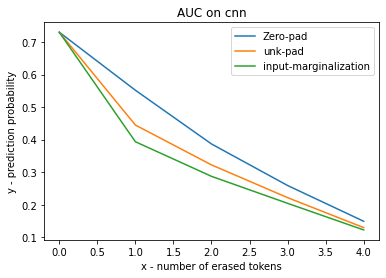

In [25]:
import matplotlib.pyplot as plt 
zero_p,unk_p,mag_p = AUC_store(cnn)
#get the average probability of a class on the 700 sentence
avg_zero = zero_p.mean(0) 
avg_unk = unk_p.mean(0)
avg_mag = mag_p.mean(0)
x = range(5)
  
# plotting the points  
plt.plot(x, avg_zero[:5]) 
plt.plot(x,avg_unk[:5])
plt.plot(x,avg_mag[:5]) 
# naming the x axis 
plt.xlabel('x - number of erased tokens') 
# naming the y axis 
plt.ylabel('y - prediction probability') 
  
# giving a title to my graph 
plt.title('AUC on cnn') 
plt.legend(['Zero-pad','unk-pad','input-marginalization']) 
# function to show the plot 
plt.show() 

In [54]:
print(avg_zero[:4].mean())
print(avg_unk[:4].mean())
print(avg_mag[:4].mean())

0.4847237728500592
0.43350271244064753
0.40241937978107195


In [ ]:
import matplotlib.pyplot as plt 
zero_p,unk_p,mag_p = AUC_store(lstm_sst2)

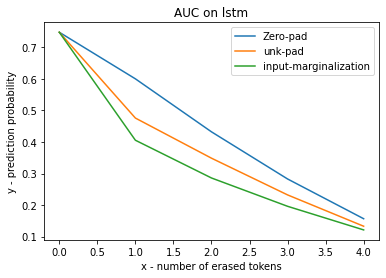

In [32]:

#get the average probability of a class on the 700 sentence
avg_zero = zero_p.mean(0) 
avg_unk = unk_p.mean(0)
avg_mag = mag_p.mean(0)
x = range(5)
  
# plotting the points  
plt.plot(x, avg_zero[:5]) 
plt.plot(x,avg_unk[:5])
plt.plot(x,avg_mag[:5]) 
# naming the x axis 
plt.xlabel('x - number of erased tokens') 
# naming the y axis 
plt.ylabel('y - prediction probability') 
  
# giving a title to my graph 
plt.title('AUC on lstm') 
plt.legend(['Zero-pad','unk-pad','input-marginalization']) 
# function to show the plot 
plt.show() 

In [33]:
print(avg_zero[:4].mean())
print(avg_unk[:4].mean())
print(avg_mag[:4].mean())

0.5155164487705768
0.45096759720891366
0.4087063311809281
